# 長程-三種價格建模

## 超參數優化與交叉驗證

### 方法：先超參數優化，再做五折交叉驗證

**流程：**
1. 在整個訓練集上使用 GridSearchCV（內層5折CV）進行超參數優化
2. 用最佳參數訓練模型
3. 使用外層5折CV評估模型性能

**優點：**
- ✅ 計算效率高：只需做一次超參數優化（每個模型）
- ✅ 實現簡單，易於理解
- ✅ 適合快速迭代和比較不同模型
- ✅ 可以獲得一組最佳超參數用於最終模型

**說明：**
- 雖然在整個訓練集上優化超參數，但 GridSearchCV 內部使用5折CV，所以實際上是基於交叉驗證分數選擇參數，數據泄漏風險較小
- 性能估計可能略微樂觀（通常差異在1-3%），但在實務中通常可接受
- 適合實務應用，可以快速獲得一組最佳參數用於部署

### 本實作說明
- 對 **RF、SVR、XGB** 進行超參數優化
- 維持一維架構（經濟艙和商務艙分別建模）
- 可以支援多次運行取平均，提高結果穩定性

---

## 超參數優化與模型評估

本節將運行超參數優化（使用 GridSearchCV 內層5折CV），然後用最佳參數進行外層5折CV評估模型性能。


In [ ]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='joblib')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    GridSearchCV, cross_val_score, KFold
)
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 中文設定 - 修復字體問題
import matplotlib
import matplotlib.font_manager as fm

# 查找可用的中文字體
def find_chinese_font():
    """查找系統中可用的中文字體"""
    # macOS 常見中文字體（按優先順序）
    mac_fonts = ['PingFang TC', 'PingFang SC', 'Heiti TC', 'Heiti SC', 'STHeiti', 'Arial Unicode MS']
    
    # 獲取所有可用字體，包括完整路徑信息
    available_fonts = {}
    for font in fm.fontManager.ttflist:
        if font.name not in available_fonts:
            available_fonts[font.name] = font.fname
    
    # 首先嘗試精確匹配
    for font in mac_fonts:
        if font in available_fonts:
            return font
    
    # 如果找不到，嘗試模糊匹配
    for font_name in available_fonts.keys():
        font_lower = font_name.lower()
        if any(keyword in font_lower for keyword in ['pingfang', 'heiti', 'unicode', 'chinese', 'tc', 'sc']):
            return font_name
    
    # 最後嘗試使用系統字體
    try:
        import platform
        if platform.system() == 'Darwin':  # macOS
            return 'PingFang TC'  # 直接指定，即使找不到也會嘗試使用
    except:
        pass
    
    return 'Arial Unicode MS'  # 默認字體

# 設置字體
chinese_font = find_chinese_font()

# 設置 matplotlib 字體參數（使用多個備選字體，確保中文顯示正常）
font_list = ['PingFang TC', 'PingFang SC', 'Heiti TC', 'Heiti SC', 
             'STHeiti', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['font.sans-serif'] = font_list
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'sans-serif'

# 設置 seaborn 樣式（seaborn 會繼承 matplotlib 的字體設置）
sns.set_style("whitegrid")
sns.set_palette("husl")

# 再次確認字體設置（seaborn 可能會影響某些設置）
plt.rcParams['font.sans-serif'] = font_list
plt.rcParams['axes.unicode_minus'] = False

# ==================== 讀取與前處理資料 ====================
file_path = '/Users/yuching/Documents/專題/merge_and_cleaned/final_data/long_flight.csv'
data = pd.read_csv(file_path)

# 分艙等
economy_class_data = data[data["艙等（主航段）"] == "經濟艙"].copy()
business_class_data = data[data["艙等（主航段）"] == "商務艙"].copy()

# One-hot encoding
categorical_cols = ['出發時段', '出發機場代號', '抵達時段', '航空聯盟組合', '航空公司組合',
                   '航空聯盟', '停靠站數量', '機型分類', '假期', '飛行時間兩段分類', '是否為平日']
economy_class_data = pd.get_dummies(economy_class_data, columns=categorical_cols, drop_first=True)
business_class_data = pd.get_dummies(business_class_data, columns=categorical_cols, drop_first=True)

# 對齊欄位
common_cols = list(set(economy_class_data.columns) & set(business_class_data.columns))
economy_class_data = economy_class_data[common_cols]
business_class_data = business_class_data[common_cols]

# 標準化數值欄
num_cols = ['停留時間_分鐘', '實際飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
scaler = StandardScaler()
economy_class_data[num_cols] = scaler.fit_transform(economy_class_data[num_cols])
business_class_data[num_cols] = scaler.transform(business_class_data[num_cols])

# 特徵欄位
target_keywords = ['出發時段_', '出發機場代號_', '抵達時段_', '航空聯盟組合_', '航空公司組合_',
                   '航空聯盟_', '停靠站數量_', '機型分類_', '假期_', '飛行時間兩段分類_', '是否為平日_']
economy_class_data_dummy_cols = [col for col in economy_class_data.columns if any(keyword in col for keyword in target_keywords)]
business_class_data_dummy_cols = [col for col in business_class_data.columns if any(keyword in col for keyword in target_keywords)]
economy_class_data_feature_cols = economy_class_data_dummy_cols + num_cols
business_class_data_feature_cols = business_class_data_dummy_cols + num_cols

# ==================== 超參數網格 ====================
rf_param_grid = {
    'n_estimators': [200, 250, 300],
    'max_depth': [20, 30],
    'min_samples_split': [4, 7, 9],
    'min_samples_leaf': [1, 2, 3, 4]
}

svr_param_grid = {
    'C': [5.0, 5.5, 6.0],
    'epsilon': [0.1, 0.15, 0.2],
    'gamma': ['scale']
}

xgb_param_grid = {
    'n_estimators': [150, 200, 250],
    'learning_rate': [0.03, 0.05, 0.15],
    'max_depth': [5, 6],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

# ==================== 先超參數優化，再做五折交叉驗證 ====================
def method1_evaluate(X, y, seed, cabin_type):
    """方法：先在整個數據集上做超參數優化（內層5折CV），然後用最佳參數做外層5折CV評估
    返回評估結果和最佳超參數"""
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=seed+1000)
    
    X_array = X.values if isinstance(X, pd.DataFrame) else X
    y_array = y.values if isinstance(y, pd.Series) else y
    
    result = {}
    best_params_dict = {}  # 保存最佳超參數
    
    # Random Forest
    rf_gs = GridSearchCV(
        RandomForestRegressor(random_state=seed, n_jobs=-1),
        param_grid=rf_param_grid,
        cv=inner_cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    rf_gs.fit(X_array, y_array)
    best_params_dict['RandomForest'] = rf_gs.best_params_
    
    rf_best = RandomForestRegressor(**rf_gs.best_params_, random_state=seed, n_jobs=-1)
    cv_scores_mse = cross_val_score(rf_best, X_array, y_array, cv=outer_cv, 
                                     scoring='neg_mean_squared_error', n_jobs=-1)
    cv_scores_r2 = cross_val_score(rf_best, X_array, y_array, cv=outer_cv, 
                                    scoring='r2', n_jobs=-1)
    cv_rmse_scores = np.sqrt(-cv_scores_mse)
    
    result['RandomForest'] = {
        'CV_RMSE': cv_rmse_scores.mean(),
        'CV_R2': cv_scores_r2.mean(),
        'CV_std_RMSE': cv_rmse_scores.std(),
        'CV_std_R2': cv_scores_r2.std()
    }
    
    # SVR
    svr_gs = GridSearchCV(
        SVR(kernel='rbf'),
        param_grid=svr_param_grid,
        cv=inner_cv,
        scoring='neg_mean_squared_error',
        n_jobs=1
    )
    svr_gs.fit(X_array, y_array)
    best_params_dict['SVR'] = svr_gs.best_params_
    
    svr_best = SVR(**svr_gs.best_params_, kernel='rbf')
    cv_scores_mse = cross_val_score(svr_best, X_array, y_array, cv=outer_cv,
                                     scoring='neg_mean_squared_error', n_jobs=-1)
    cv_scores_r2 = cross_val_score(svr_best, X_array, y_array, cv=outer_cv,
                                    scoring='r2', n_jobs=-1)
    cv_rmse_scores = np.sqrt(-cv_scores_mse)
    
    result['SVR'] = {
        'CV_RMSE': cv_rmse_scores.mean(),
        'CV_R2': cv_scores_r2.mean(),
        'CV_std_RMSE': cv_rmse_scores.std(),
        'CV_std_R2': cv_scores_r2.std()
    }
    
    # XGBoost
    xgb_gs = GridSearchCV(
        XGBRegressor(random_state=seed, n_jobs=-1, verbosity=0, tree_method='hist'),
        param_grid=xgb_param_grid,
        cv=inner_cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    xgb_gs.fit(X_array, y_array)
    best_params_dict['XGBoost'] = xgb_gs.best_params_
    
    xgb_best = XGBRegressor(**xgb_gs.best_params_, random_state=seed, 
                            n_jobs=-1, verbosity=0, tree_method='hist')
    cv_scores_mse = cross_val_score(xgb_best, X_array, y_array, cv=outer_cv,
                                     scoring='neg_mean_squared_error', n_jobs=-1)
    cv_scores_r2 = cross_val_score(xgb_best, X_array, y_array, cv=outer_cv,
                                    scoring='r2', n_jobs=-1)
    cv_rmse_scores = np.sqrt(-cv_scores_mse)
    
    result['XGBoost'] = {
        'CV_RMSE': cv_rmse_scores.mean(),
        'CV_R2': cv_scores_r2.mean(),
        'CV_std_RMSE': cv_rmse_scores.std(),
        'CV_std_R2': cv_scores_r2.std()
    }
    
    return result, best_params_dict

# ==================== 運行超參數優化並收集結果 ====================
seed = 123
all_results = {}
best_params_all = {}

print("=" * 70)
print("開始運行超參數優化與模型評估...")
print("=" * 70)

for target in ['平均價格_log', '中位數價格_log', '最低價格_log']:
    print(f"\n處理目標變數：{target}")
    print("-" * 70)
    
    # 經濟艙
    print(f"處理 {target} - 經濟艙...")
    method1_eco, best_params_eco = method1_evaluate(
        economy_class_data[economy_class_data_feature_cols],
        economy_class_data[target],
        seed,
        "經濟艙"
    )
    
    # 商務艙
    print(f"處理 {target} - 商務艙...")
    method1_biz, best_params_biz = method1_evaluate(
        business_class_data[business_class_data_feature_cols],
        business_class_data[target],
        seed,
        "商務艙"
    )
    
    # 保存結果和最佳超參數
    all_results[target] = {
        '經濟艙': method1_eco,
        '商務艙': method1_biz
    }
    
    best_params_all[target] = {
        '經濟艙': best_params_eco,
        '商務艙': best_params_biz
    }
    
    print(f"✓ {target} 完成")
    print(f"  經濟艙最佳參數: {best_params_eco}")
    print(f"  商務艙最佳參數: {best_params_biz}")

print("\n" + "=" * 70)
print("所有運行完成！")
print("=" * 70)

開始運行超參數優化與模型評估...

處理目標變數：平均價格_log
----------------------------------------------------------------------
處理 平均價格_log - 經濟艙...
處理 平均價格_log - 商務艙...
✓ 平均價格_log 完成
  經濟艙最佳參數: {'RandomForest': {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 300}, 'SVR': {'C': 6.0, 'epsilon': 0.1, 'gamma': 'scale'}, 'XGBoost': {'colsample_bytree': 0.8, 'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 250, 'subsample': 0.8}}
  商務艙最佳參數: {'RandomForest': {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 300}, 'SVR': {'C': 6.0, 'epsilon': 0.1, 'gamma': 'scale'}, 'XGBoost': {'colsample_bytree': 0.8, 'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 250, 'subsample': 0.8}}

處理目標變數：中位數價格_log
----------------------------------------------------------------------
處理 中位數價格_log - 經濟艙...
處理 中位數價格_log - 商務艙...
✓ 中位數價格_log 完成
  經濟艙最佳參數: {'RandomForest': {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 300}, 'SVR': 


開始創建視覺化圖表...

生成 平均價格_log 的結果圖表...


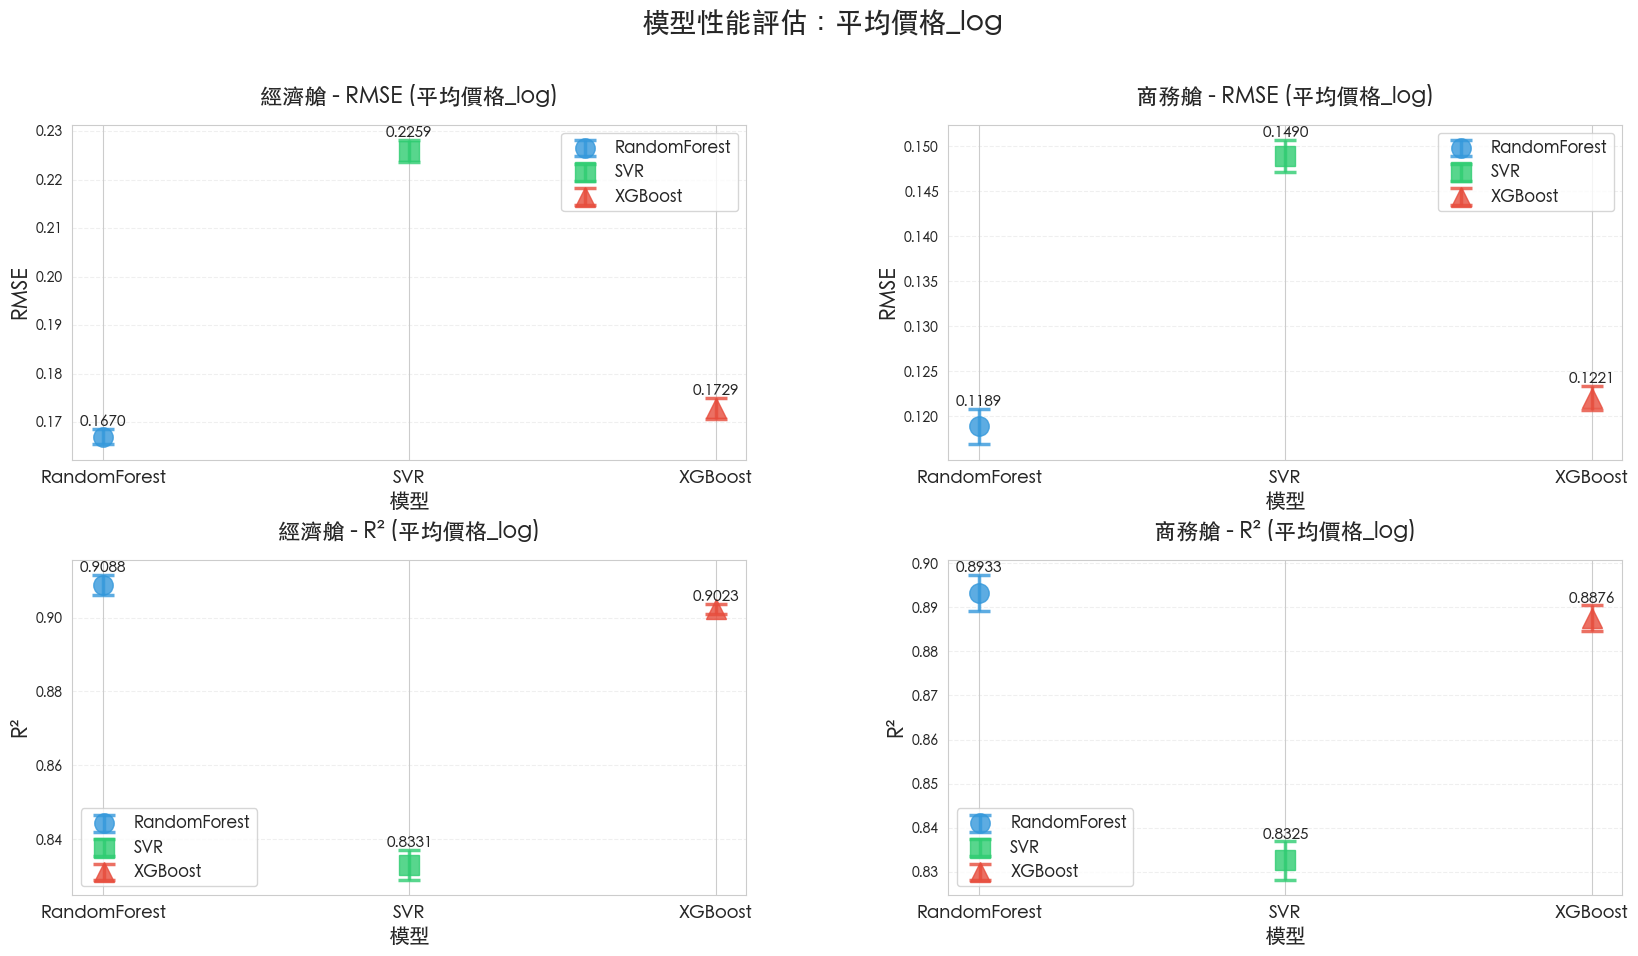

✓ 平均價格_log 圖表完成

生成 中位數價格_log 的結果圖表...


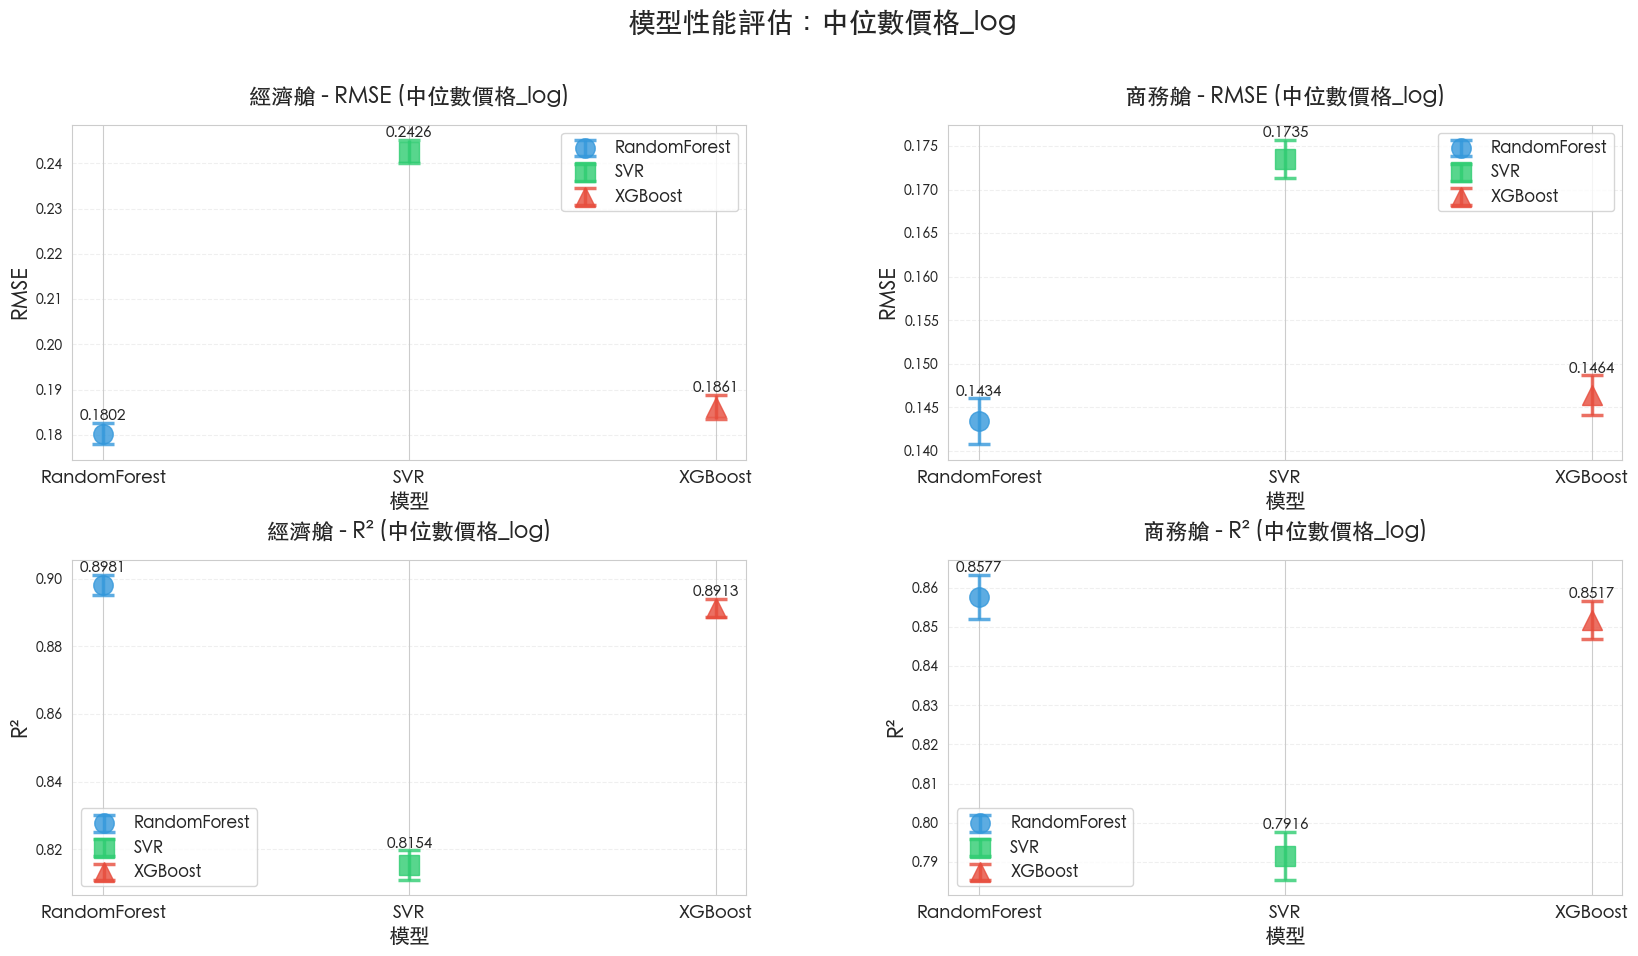

✓ 中位數價格_log 圖表完成

生成 最低價格_log 的結果圖表...


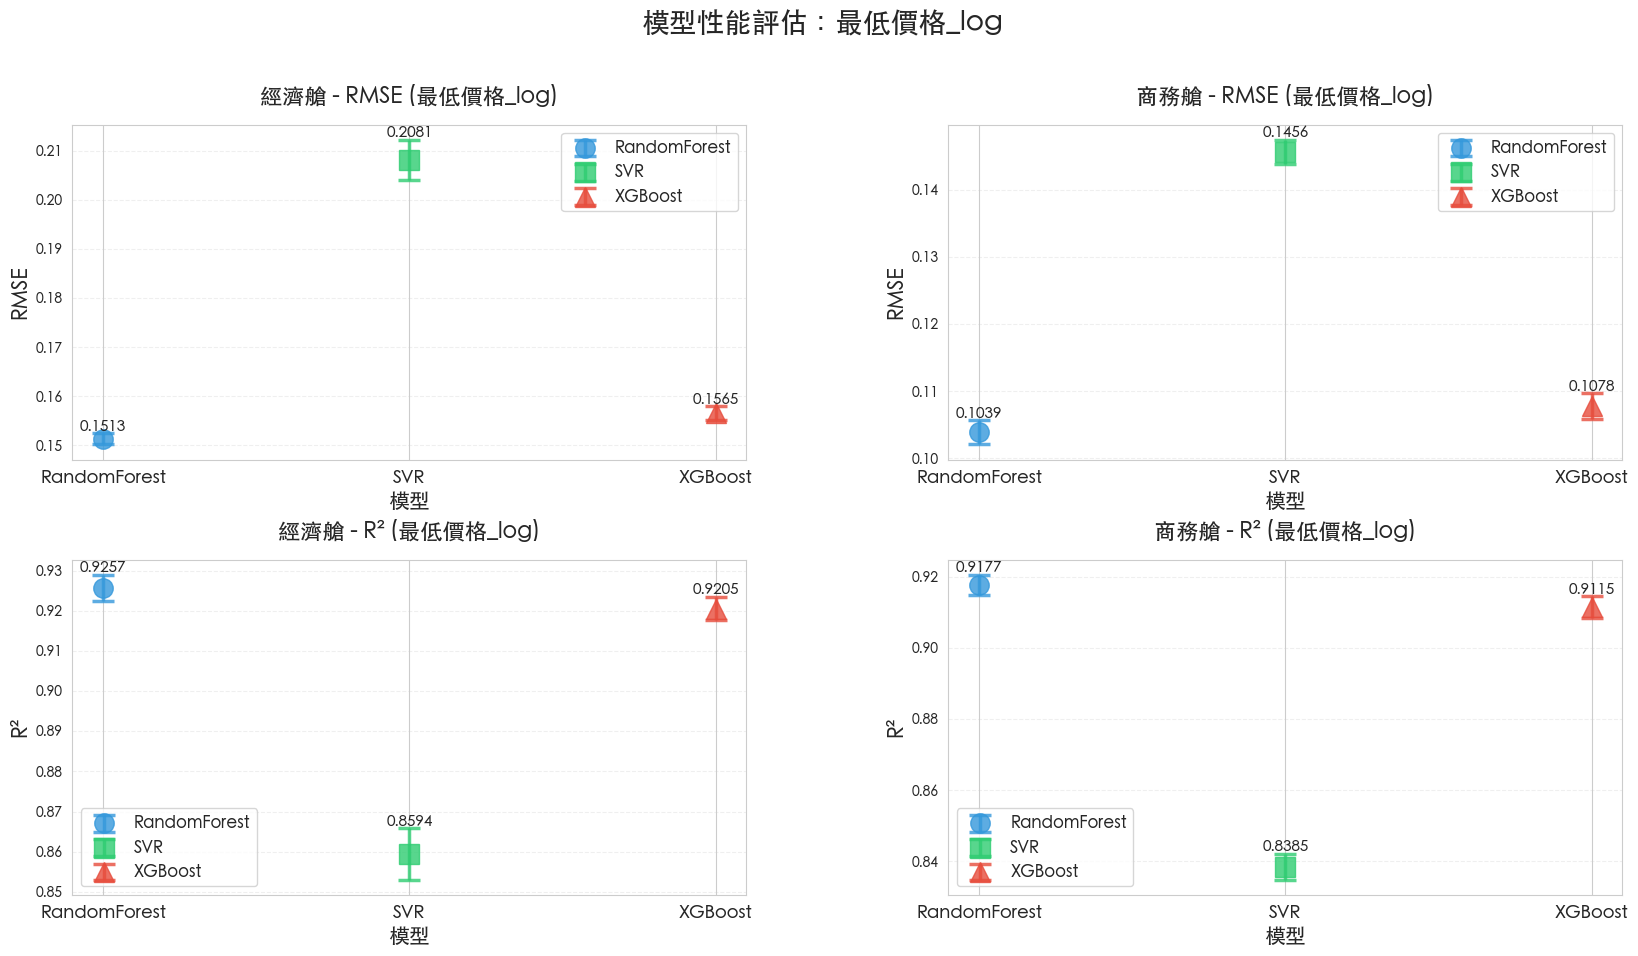

✓ 最低價格_log 圖表完成


In [4]:
# ==================== 視覺化函數 ====================

def create_results_plots(all_results, best_params_all=None):
    """創建模型結果的視覺化圖表"""
    
    # 確保字體設置正確（在創建圖表前重新設置）
    # 直接設置字體列表（macOS 系統字體，按優先順序）
    font_list = ['PingFang TC', 'PingFang SC', 'Heiti TC', 'Heiti SC', 
                 'STHeiti', 'Arial Unicode MS', 'DejaVu Sans']
    plt.rcParams['font.sans-serif'] = font_list
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.family'] = 'sans-serif'
    
    # 目標變數標籤映射
    target_labels = {
        '平均價格_log': '對數平均價格指標',
        '中位數價格_log': '對數中位數價格指標',
        '最低價格_log': '對數最低價格指標'
    }
    
    models = ['RandomForest', 'SVR', 'XGBoost']
    
    # 為每個目標變數創建圖表
    targets = list(all_results.keys())
    for target in targets:
        fig = plt.figure(figsize=(20, 10))
        gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
        
        # 獲取目標變數的顯示標籤
        target_label = target_labels.get(target, target)
        
        # 準備數據（新結構：all_results[target]['經濟艙'] 和 all_results[target]['商務艙']）
        eco_results = all_results[target]['經濟艙']
        biz_results = all_results[target]['商務艙']
        
        # 1. RMSE（經濟艙）
        ax1 = fig.add_subplot(gs[0, 0])
        rmse_values = [eco_results[m]['CV_RMSE'] for m in models]
        rmse_errors = [eco_results[m]['CV_std_RMSE'] for m in models]
        
        x = np.arange(len(models))
        colors = ['#3498db', '#2ecc71', '#e74c3c']
        markers = ['o', 's', '^']
        
        for i, (val, err, color, marker) in enumerate(zip(rmse_values, rmse_errors, colors, markers)):
            ax1.errorbar(x[i], val, yerr=err, fmt=marker, markersize=14, 
                        capsize=8, capthick=2.5, elinewidth=2.5,
                        color=color, alpha=0.8, linewidth=2.5, label=models[i])
            # 添加數值標籤
            ax1.text(x[i], val + err, f'{val:.4f}', ha='center', va='bottom', 
                    fontsize=11, fontweight='bold')
        
        ax1.set_xlabel('模型', fontsize=15, fontweight='bold')
        ax1.set_ylabel('RMSE', fontsize=15, fontweight='bold')
        ax1.set_title(f'經濟艙 - RMSE ({target_label})', fontsize=16, fontweight='bold', pad=15)
        ax1.set_xticks(x)
        ax1.set_xticklabels(models, fontsize=13)
        ax1.legend(fontsize=12, loc='best')
        ax1.grid(axis='y', alpha=0.3, linestyle='--')
        
        # 2. RMSE（商務艙）
        ax2 = fig.add_subplot(gs[0, 1])
        rmse_values = [biz_results[m]['CV_RMSE'] for m in models]
        rmse_errors = [biz_results[m]['CV_std_RMSE'] for m in models]
        
        for i, (val, err, color, marker) in enumerate(zip(rmse_values, rmse_errors, colors, markers)):
            ax2.errorbar(x[i], val, yerr=err, fmt=marker, markersize=14, 
                        capsize=8, capthick=2.5, elinewidth=2.5,
                        color=color, alpha=0.8, linewidth=2.5, label=models[i])
            # 添加數值標籤
            ax2.text(x[i], val + err, f'{val:.4f}', ha='center', va='bottom', 
                    fontsize=11, fontweight='bold')
        
        ax2.set_xlabel('模型', fontsize=15, fontweight='bold')
        ax2.set_ylabel('RMSE', fontsize=15, fontweight='bold')
        ax2.set_title(f'商務艙 - RMSE ({target_label})', fontsize=16, fontweight='bold', pad=15)
        ax2.set_xticks(x)
        ax2.set_xticklabels(models, fontsize=13)
        ax2.legend(fontsize=12, loc='best')
        ax2.grid(axis='y', alpha=0.3, linestyle='--')
        
        # 3. R²（經濟艙）
        ax3 = fig.add_subplot(gs[1, 0])
        r2_values = [eco_results[m]['CV_R2'] for m in models]
        r2_errors = [eco_results[m]['CV_std_R2'] for m in models]
        
        for i, (val, err, color, marker) in enumerate(zip(r2_values, r2_errors, colors, markers)):
            ax3.errorbar(x[i], val, yerr=err, fmt=marker, markersize=14, 
                        capsize=8, capthick=2.5, elinewidth=2.5,
                        color=color, alpha=0.8, linewidth=2.5, label=models[i])
            # 添加數值標籤
            ax3.text(x[i], val + err, f'{val:.4f}', ha='center', va='bottom', 
                    fontsize=11, fontweight='bold')
        
        ax3.set_xlabel('模型', fontsize=15, fontweight='bold')
        ax3.set_ylabel('R²', fontsize=15, fontweight='bold')
        ax3.set_title(f'經濟艙 - R² ({target_label})', fontsize=16, fontweight='bold', pad=15)
        ax3.set_xticks(x)
        ax3.set_xticklabels(models, fontsize=13)
        ax3.legend(fontsize=12, loc='best')
        ax3.grid(axis='y', alpha=0.3, linestyle='--')
        
        # 4. R²（商務艙）
        ax4 = fig.add_subplot(gs[1, 1])
        r2_values = [biz_results[m]['CV_R2'] for m in models]
        r2_errors = [biz_results[m]['CV_std_R2'] for m in models]
        
        for i, (val, err, color, marker) in enumerate(zip(r2_values, r2_errors, colors, markers)):
            ax4.errorbar(x[i], val, yerr=err, fmt=marker, markersize=14, 
                        capsize=8, capthick=2.5, elinewidth=2.5,
                        color=color, alpha=0.8, linewidth=2.5, label=models[i])
            # 添加數值標籤
            ax4.text(x[i], val + err, f'{val:.4f}', ha='center', va='bottom', 
                    fontsize=11, fontweight='bold')
        
        ax4.set_xlabel('模型', fontsize=15, fontweight='bold')
        ax4.set_ylabel('R²', fontsize=15, fontweight='bold')
        ax4.set_title(f'商務艙 - R² ({target_label})', fontsize=16, fontweight='bold', pad=15)
        ax4.set_xticks(x)
        ax4.set_xticklabels(models, fontsize=13)
        ax4.legend(fontsize=12, loc='best')
        ax4.grid(axis='y', alpha=0.3, linestyle='--')
        

        plt.suptitle(f'模型性能評估：{target_label}', fontsize=20, fontweight='bold', y=0.995)
        plt.show()

# 創建所有圖表
print("\n" + "=" * 70)
print("開始創建視覺化圖表...")
print("=" * 70)

for target in ['平均價格_log', '中位數價格_log', '最低價格_log']:
    print(f"\n生成 {target} 的結果圖表...")
    create_results_plots({target: all_results[target]}, best_params_all)
    print(f"✓ {target} 圖表完成")

In [6]:
# ==================== 數值結果總結表格 ====================

def print_summary_table(all_results):
    """打印詳細的數值結果表格"""
    
    targets = ['平均價格_log', '中位數價格_log', '最低價格_log']
    models = ['RandomForest', 'SVR', 'XGBoost']
    
    for target in targets:
        print("\n" + "=" * 100)
        print(f"📊 {target} - 超參數優化結果")
        print("=" * 100)
        
        eco_results = all_results[target]['經濟艙']
        biz_results = all_results[target]['商務艙']
        
        for cabin_name, results in [('經濟艙', eco_results), ('商務艙', biz_results)]:
            print(f"\n【{cabin_name}】")
            print("-" * 100)
            print(f"{'模型':<15} {'RMSE':<20} {'R²':<20}")
            print("-" * 100)
            
            for model in models:
                rmse = results[model]['CV_RMSE']
                rmse_std = results[model]['CV_std_RMSE']
                r2 = results[model]['CV_R2']
                r2_std = results[model]['CV_std_R2']
                
                print(f"{model:<15} {rmse:.4f} ± {rmse_std:.4f}  {r2:.4f} ± {r2_std:.4f}")
            print()

# 打印總結表格
print_summary_table(all_results)


📊 平均價格_log - 超參數優化結果

【經濟艙】
----------------------------------------------------------------------------------------------------
模型              RMSE                 R²                  
----------------------------------------------------------------------------------------------------
RandomForest    0.1670 ± 0.0016  0.9088 ± 0.0027
SVR             0.2259 ± 0.0023  0.8331 ± 0.0040
XGBoost         0.1729 ± 0.0021  0.9023 ± 0.0014


【商務艙】
----------------------------------------------------------------------------------------------------
模型              RMSE                 R²                  
----------------------------------------------------------------------------------------------------
RandomForest    0.1189 ± 0.0020  0.8933 ± 0.0040
SVR             0.1490 ± 0.0018  0.8325 ± 0.0043
XGBoost         0.1221 ± 0.0013  0.8876 ± 0.0030


📊 中位數價格_log - 超參數優化結果

【經濟艙】
----------------------------------------------------------------------------------------------------
模型              R

## 30 次平均


In [1]:
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import Parallel, delayed, parallel_backend
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# --------------------------
# 設定與前處理
# --------------------------
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

file_path = '/Users/yuching/Documents/專題/merge_and_cleaned/final_data/long_flight.csv'
n_runs     = 30
seeds      = list(range(n_runs))

target_keywords = [
    '出發時段_', '出發機場代號_', '抵達時段_',
    '航空聯盟組合_', '航空公司組合_', '航空聯盟_',
    '停靠站數量_', '機型分類_', '假期_',
    '飛行時間兩段分類_', '是否為平日_'
]
num_cols = [
    '停留時間_分鐘', '實際飛行時間_分鐘',
    '經濟指標', '機場指標', 'competing_flights'
]
categorical_cols = [
    '出發時段', '出發機場代號', '抵達時段',
    '航空聯盟組合', '航空公司組合', '航空聯盟',
    '停靠站數量', '機型分類', '假期',
    '飛行時間兩段分類', '是否為平日'
]

data      = pd.read_csv(file_path)
econ_data = data[data["艙等（主航段）"]=="經濟艙"].copy()
biz_data  = data[data["艙等（主航段）"]=="商務艙"].copy()

econ_data = pd.get_dummies(econ_data, columns=categorical_cols, drop_first=True)
biz_data  = pd.get_dummies(biz_data,  columns=categorical_cols, drop_first=True)

common    = list(set(econ_data.columns)&set(biz_data.columns))
econ_data = econ_data[common]
biz_data  = biz_data[common]

scaler    = StandardScaler()
econ_data[num_cols] = scaler.fit_transform(econ_data[num_cols])
biz_data [num_cols] = scaler.transform(   biz_data [num_cols])

def get_features(df):
    dummies = [c for c in df.columns if any(k in c for k in target_keywords)]
    return dummies + num_cols

econ_feats = get_features(econ_data)
biz_feats  = get_features(biz_data)

# --------------------------
# 最佳參數表
# --------------------------
best_params = {
    '平均價格_log': {
        '經濟艙': {
            'RandomForest': {'n_estimators':300,'max_depth':20,'min_samples_split':9,'min_samples_leaf':1},
            'SVR'         : {'C':6.0,'epsilon':0.1,'gamma':'scale'},
            'XGBoost'     : {'n_estimators':250,'learning_rate':0.15,'max_depth':6,'subsample':0.8,'colsample_bytree':0.8}
        },
        '商務艙': {
            'RandomForest': {'n_estimators':300,'max_depth':20,'min_samples_split':9,'min_samples_leaf':1},
            'SVR'         : {'C':6.0,'epsilon':0.1,'gamma':'scale'},
            'XGBoost'     : {'n_estimators':250,'learning_rate':0.15,'max_depth':6,'subsample':0.8,'colsample_bytree':0.8}
        }
    },
    '中位數價格_log': {
        '經濟艙': {
            'RandomForest': {'n_estimators':300,'max_depth':20,'min_samples_split':9,'min_samples_leaf':1},
            'SVR'         : {'C':6.0,'epsilon':0.1,'gamma':'scale'},
            'XGBoost'     : {'n_estimators':250,'learning_rate':0.15,'max_depth':6,'subsample':0.8,'colsample_bytree':0.8}
        },
        '商務艙': {
            'RandomForest': {'n_estimators':300,'max_depth':20,'min_samples_split':9,'min_samples_leaf':1},
            'SVR'         : {'C':6.0,'epsilon':0.1,'gamma':'scale'},
            'XGBoost'     : {'n_estimators':250,'learning_rate':0.15,'max_depth':6,'subsample':0.8,'colsample_bytree':0.7}
        }
    },
    '最低價格_log': {
        '經濟艙': {
            'RandomForest': {'n_estimators':200,'max_depth':30,'min_samples_split':9,'min_samples_leaf':1},
            'SVR'         : {'C':6.0,'epsilon':0.1,'gamma':'scale'},
            'XGBoost'     : {'n_estimators':250,'learning_rate':0.15,'max_depth':6,'subsample':0.8,'colsample_bytree':0.8}
        },
        '商務艙': {
            'RandomForest': {'n_estimators':250,'max_depth':30,'min_samples_split':9,'min_samples_leaf':1},
            'SVR'         : {'C':6.0,'epsilon':0.1,'gamma':'scale'},
            'XGBoost'     : {'n_estimators':250,'learning_rate':0.15,'max_depth':6,'subsample':0.8,'colsample_bytree':0.8}
        }
    }
}

# 打印最佳參數表
print("\n" + "=" * 100)
print("📋 30次運行使用的最佳超參數表")
print("=" * 100)
for target in ['平均價格_log', '中位數價格_log', '最低價格_log']:
    print(f"\n【{target}】")
    print("-" * 100)
    for cabin in ['經濟艙', '商務艙']:
        print(f"\n  {cabin}:")
        params = best_params[target][cabin]
        for model in ['RandomForest', 'SVR', 'XGBoost']:
            print(f"    {model}: {params[model]}")
print("\n" + "=" * 100)

# --------------------------
# run_model
# --------------------------
def run_model(seed, X, y, params):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=seed)
    n_test, p = len(yte), X.shape[1]
    out = {}
    models = {
        'RandomForest': RandomForestRegressor(random_state=seed, n_jobs=1, **params['RandomForest']),
        'SVR'         : SVR(**params['SVR']),
        'XGBoost'     : XGBRegressor(random_state=seed, n_jobs=1, tree_method='hist', **params['XGBoost'])
    }
    for name, mdl in models.items():
        mdl.fit(Xtr, ytr)
        pred = mdl.predict(Xte)
        mse  = mean_squared_error(yte, pred)
        r2   = r2_score(yte, pred)
        adj  = 1 - (1-r2)*(n_test-1)/(n_test-p-1)
        out[name] = {'MSE': mse, 'R2': r2, 'Adjusted_R2': adj}
    return out

# --------------------------
# process_results & plot
# --------------------------
def process_results(results_list):
    agg = {m:{'MSE':[], 'R2':[]} for m in results_list[0].keys()}
    for res in results_list:
        for m in agg:
            agg[m]['MSE'].append(res[m]['MSE'])
            agg[m]['R2'].append(res[m]['R2'])
    summary = {m:{'Average MSE':np.mean(v['MSE']), 'Average R2':np.mean(v['R2'])}
               for m,v in agg.items()}
    return summary, agg

def plot_r2_boxplots_all_targets(all_r2_data, cabin_type, n_runs):
    """繪製按價格指標分組的R2箱型圖"""
    # 設置字體
    font_list = ['PingFang TC', 'PingFang SC', 'Heiti TC', 'Heiti SC', 
                 'STHeiti', 'Arial Unicode MS', 'DejaVu Sans']
    plt.rcParams['font.sans-serif'] = font_list
    plt.rcParams['axes.unicode_minus'] = False
    
    # 準備數據
    # all_r2_data 格式: {'平均價格_log': {'RandomForest': [r2_list], 'SVR': [r2_list], 'XGBoost': [r2_list]}, ...}
    target_labels = {
        '平均價格_log': '對數平均價格指標',
        '中位數價格_log': '對數中位數價格指標',
        '最低價格_log': '對數最低價格指標'
    }
    
    # 將數據轉換為適合繪圖的DataFrame
    # 模型名稱映射
    model_name_map = {
        'RandomForest': 'RF',
        'SVR': 'SVR',
        'XGBoost': 'XGB'
    }
    
    plot_data = []
    for target in ['平均價格_log', '中位數價格_log', '最低價格_log']:
        target_label = target_labels[target]
        for model in ['RandomForest', 'SVR', 'XGBoost']:
            r2_values = all_r2_data[target][model]
            model_display_name = model_name_map[model]
            for r2_val in r2_values:
                plot_data.append({
                    '價格指標': target_label,
                    '模型': model_display_name,
                    'R2': r2_val
                })
    
    df_plot = pd.DataFrame(plot_data)
    
    # 設置模型顏色和順序
    model_colors = {
        'RF': 'lightgreen',
        'SVR': 'wheat',  # 淺棕色/橙色
        'XGB': 'lightblue'
    }
    model_order = ['RF', 'SVR', 'XGB']
    target_order = [target_labels[t] for t in ['平均價格_log', '中位數價格_log', '最低價格_log']]
    
    # 創建圖表
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # 使用seaborn繪製箱型圖
    sns.boxplot(data=df_plot, x='價格指標', y='R2', hue='模型', 
                palette=model_colors, order=target_order, hue_order=model_order, ax=ax)
    
    ax.set_xlabel('價格指標', fontsize=14, fontweight='bold')
    ax.set_ylabel('R2', fontsize=14, fontweight='bold')
    ax.set_title(f'R2分數比較 - {cabin_type} ({n_runs}次運行)', fontsize=16, fontweight='bold')
    ax.legend(title='模型', fontsize=12, title_fontsize=12, loc='best')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()

def plot_mse_boxplots_all_targets(all_mse_data, cabin_type, n_runs):
    """繪製按價格指標分組的MSE箱型圖"""
    # 設置字體
    font_list = ['PingFang TC', 'PingFang SC', 'Heiti TC', 'Heiti SC', 
                 'STHeiti', 'Arial Unicode MS', 'DejaVu Sans']
    plt.rcParams['font.sans-serif'] = font_list
    plt.rcParams['axes.unicode_minus'] = False
    
    # 準備數據
    # all_mse_data 格式: {'平均價格_log': {'RandomForest': [mse_list], 'SVR': [mse_list], 'XGBoost': [mse_list]}, ...}
    target_labels = {
        '平均價格_log': '對數平均價格指標',
        '中位數價格_log': '對數中位數價格指標',
        '最低價格_log': '對數最低價格指標'
    }
    
    # 將數據轉換為適合繪圖的DataFrame
    # 模型名稱映射
    model_name_map = {
        'RandomForest': 'RF',
        'SVR': 'SVR',
        'XGBoost': 'XGB'
    }
    
    plot_data = []
    for target in ['平均價格_log', '中位數價格_log', '最低價格_log']:
        target_label = target_labels[target]
        for model in ['RandomForest', 'SVR', 'XGBoost']:
            mse_values = all_mse_data[target][model]
            model_display_name = model_name_map[model]
            for mse_val in mse_values:
                plot_data.append({
                    '價格指標': target_label,
                    '模型': model_display_name,
                    'MSE': mse_val
                })
    
    df_plot = pd.DataFrame(plot_data)
    
    # 設置模型顏色和順序
    model_colors = {
        'RF': 'lightgreen',
        'SVR': 'wheat',  # 淺棕色/橙色
        'XGB': 'lightblue'
    }
    model_order = ['RF', 'SVR', 'XGB']
    target_order = [target_labels[t] for t in ['平均價格_log', '中位數價格_log', '最低價格_log']]
    
    # 創建圖表
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # 使用seaborn繪製箱型圖
    sns.boxplot(data=df_plot, x='價格指標', y='MSE', hue='模型', 
                palette=model_colors, order=target_order, hue_order=model_order, ax=ax)
    
    ax.set_xlabel('價格指標', fontsize=14, fontweight='bold')
    ax.set_ylabel('MSE', fontsize=14, fontweight='bold')
    ax.set_title(f'MSE分數比較 - {cabin_type} ({n_runs}次運行)', fontsize=16, fontweight='bold')
    ax.legend(title='模型', fontsize=12, title_fontsize=12, loc='best')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()

# --------------------------
# 執行主程式
# --------------------------
# 收集所有價格指標的數據
all_econ_r2 = {}
all_biz_r2 = {}
all_econ_mse = {}
all_biz_mse = {}

for target in ['平均價格_log','中位數價格_log','最低價格_log']:
    econ_p = best_params[target]['經濟艙']
    biz_p  = best_params[target]['商務艙']

    with parallel_backend('threading'):
        econ_out = Parallel(n_jobs=-1)(
            delayed(run_model)(s, econ_data[econ_feats], econ_data[target], econ_p)
            for s in seeds
        )
        biz_out  = Parallel(n_jobs=-1)(
            delayed(run_model)(s, biz_data[biz_feats],  biz_data[target],  biz_p)
            for s in seeds
        )

    econ_summary, econ_agg = process_results(econ_out)
    biz_summary,  biz_agg  = process_results(biz_out)

    print(f"\n==== {target} 平均表現 ====")
    for cabin, summ in [('經濟艙', econ_summary), ('商務艙', biz_summary)]:
        print(f"{cabin}:")
        for model, scores in summ.items():
            print(f"  {model}: MSE={scores['Average MSE']:.4f}, R2={scores['Average R2']:.4f}")

    # 收集R2和MSE數據
    all_econ_r2[target] = {m: v['R2'] for m, v in econ_agg.items()}
    all_biz_r2[target] = {m: v['R2'] for m, v in biz_agg.items()}
    all_econ_mse[target] = {m: v['MSE'] for m, v in econ_agg.items()}
    all_biz_mse[target] = {m: v['MSE'] for m, v in biz_agg.items()}

print("\n" + "=" * 70)
print("30次運行運算完成！數據已收集完成。")


📋 30次運行使用的最佳超參數表

【平均價格_log】
----------------------------------------------------------------------------------------------------

  經濟艙:
    RandomForest: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 1}
    SVR: {'C': 6.0, 'epsilon': 0.1, 'gamma': 'scale'}
    XGBoost: {'n_estimators': 250, 'learning_rate': 0.15, 'max_depth': 6, 'subsample': 0.8, 'colsample_bytree': 0.8}

  商務艙:
    RandomForest: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 1}
    SVR: {'C': 6.0, 'epsilon': 0.1, 'gamma': 'scale'}
    XGBoost: {'n_estimators': 250, 'learning_rate': 0.15, 'max_depth': 6, 'subsample': 0.8, 'colsample_bytree': 0.8}

【中位數價格_log】
----------------------------------------------------------------------------------------------------

  經濟艙:
    RandomForest: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 1}
    SVR: {'C': 6.0, 'epsilon': 0.1, 'gamma': 'scale'}
    XGBoost: {'n_estima

⚠ 未找到已保存的結果文件
請先運行上一個cell進行計算並保存結果

繪製R2箱型圖...


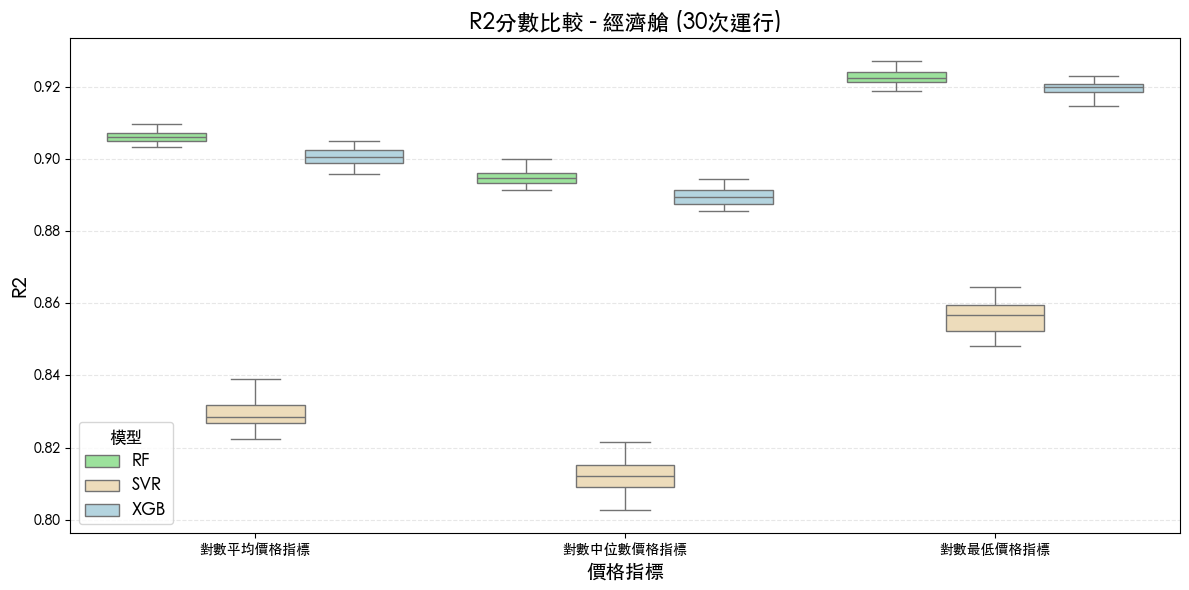

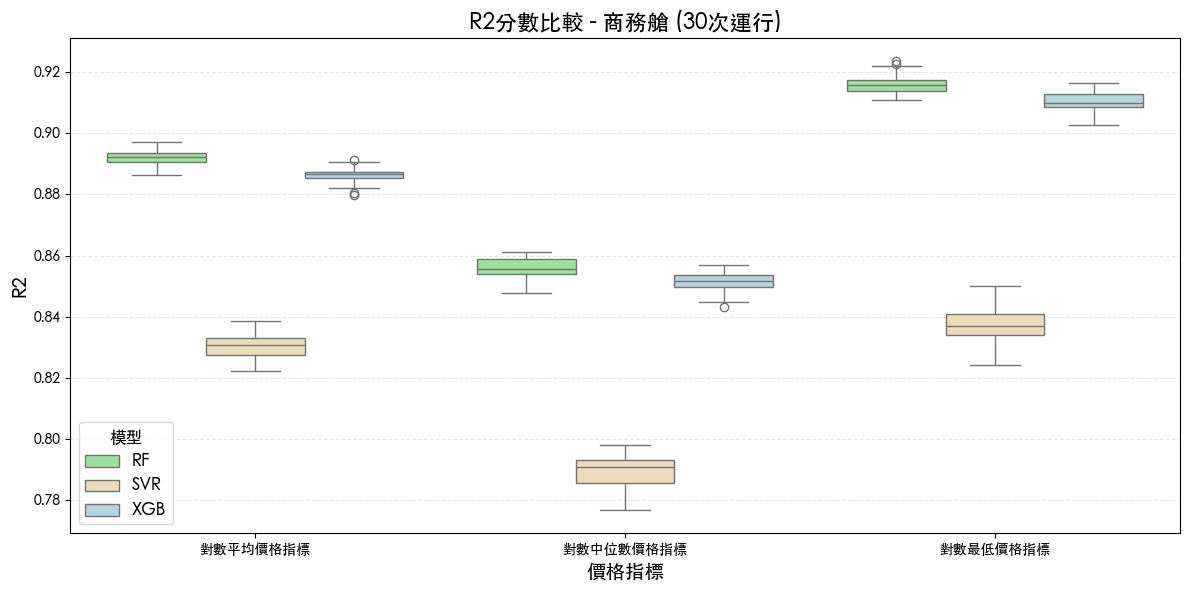


繪製MSE箱型圖...


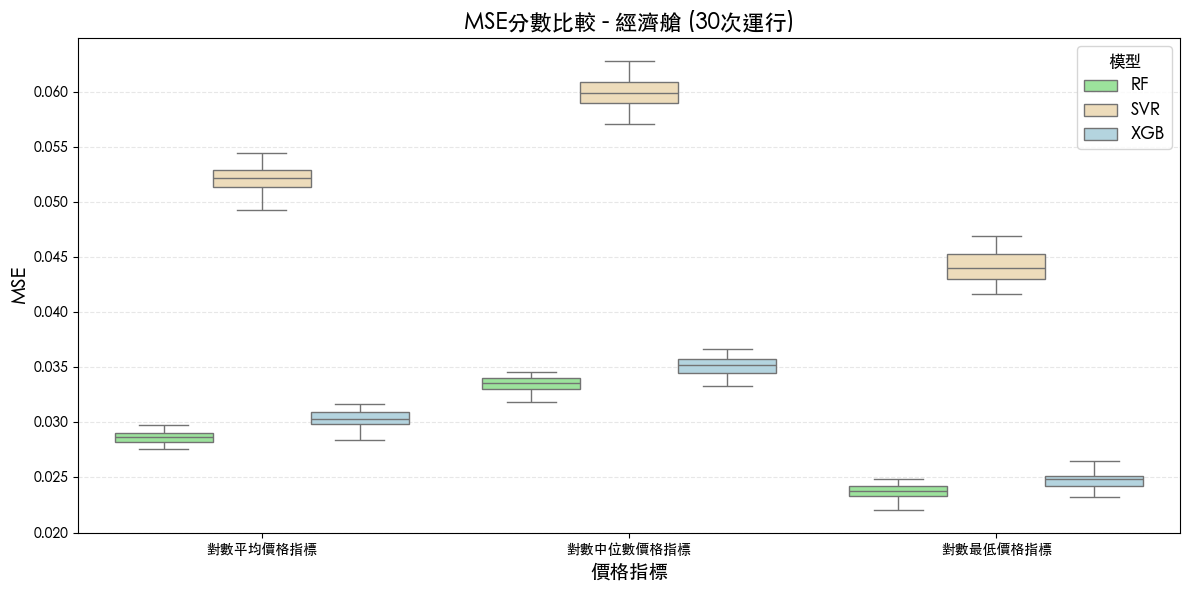

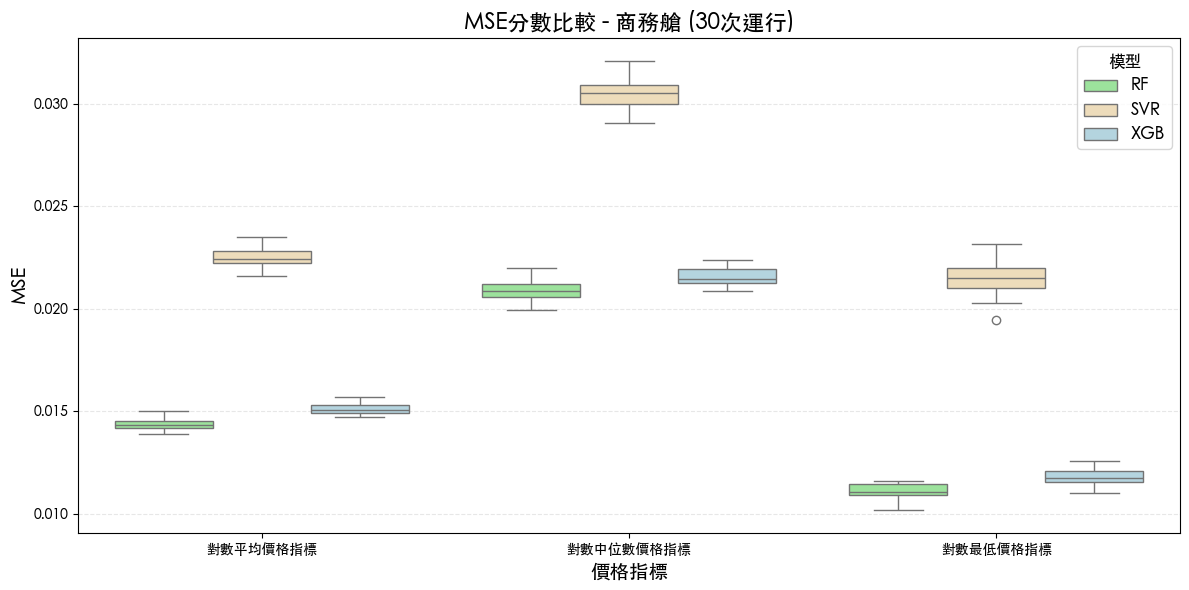

In [2]:
# ==================== 繪製箱型圖 ====================
# 此cell只需要運行繪圖函數，不需要重新運算
# 如果上一個cell已經運算完成，直接運行此cell即可
# 也可以直接加載已保存的結果文件

import pickle
import os

results_file = os.path.join('results', 'long_model_results.pkl')

# 嘗試加載已保存的結果
if os.path.exists(results_file):
    print("=" * 70)
    print("發現已保存的結果文件，正在加載...")
    print("=" * 70)
    with open(results_file, 'rb') as f:
        results_data = pickle.load(f)
    all_econ_r2 = results_data['all_econ_r2']
    all_biz_r2 = results_data['all_biz_r2']
    all_econ_mse = results_data['all_econ_mse']
    all_biz_mse = results_data['all_biz_mse']
    n_runs = results_data['n_runs']
    print(f"✓ 結果已加載（{n_runs}次運行）")
    print("=" * 70)
else:
    print("=" * 70)
    print("⚠ 未找到已保存的結果文件")
    print("請先運行上一個cell進行計算並保存結果")
    print("=" * 70)

print("\n" + "=" * 70)
print("繪製R2箱型圖...")
print("=" * 70)
plot_r2_boxplots_all_targets(all_econ_r2, '經濟艙', n_runs)
plot_r2_boxplots_all_targets(all_biz_r2, '商務艙', n_runs)

print("\n" + "=" * 70)
print("繪製MSE箱型圖...")
print("=" * 70)
plot_mse_boxplots_all_targets(all_econ_mse, '經濟艙', n_runs)
plot_mse_boxplots_all_targets(all_biz_mse, '商務艙', n_runs)